In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations
from sklearn.linear_model import LinearRegression
import math

import sys
sys.path.append('/public/src')
from factor_evaluation_server import FactorEvaluation, DataService

In [4]:
def factor_1(df, ema_period=20, atr_period=10, multiplier=2):
    '''凯尔特纳通道：基于ATR的波动通道'''
    ema = df['close'].ewm(span=ema_period, adjust=False).mean()
    
    # 计算ATR
    high_low = df['high'] - df['low']
    high_close = abs(df['high'] - df['close'].shift(1))
    low_close = abs(df['low'] - df['close'].shift(1))
    true_range = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    atr = true_range.ewm(span=atr_period, adjust=False).mean()
    
    # 计算通道宽度
    channel_width = multiplier * atr
    
    factor = (df['close'] - (ema + channel_width)) / (2 * channel_width)
    
    return factor

def factor_2(df):
    """
    聪明钱_市场状态过滤
    """
    # 动态窗口：根据波动率调整回溯期
    volatility = df['close'].pct_change().rolling(96).std()
    
    # 处理NaN和inf问题 - 填充缺失值，避免除以零
    volatility = volatility.fillna(volatility.mean())  # 填充NaN为均值
    volatility = volatility.replace(0, 1e-6)           # 避免除以零
    volatility = np.clip(volatility, 1e-6, None)        # 确保最小正值
    
    # 计算窗口大小并确保为整数
    window_size = (960 / (volatility * 100 + 1))
    window_size = np.nan_to_num(window_size, nan=480)   # 替换NaN为默认值
    window_size = np.clip(window_size, 480, 1440).astype(int)
    
    # 预计算关键指标
    avg_price = (df['open'] + df['high'] + df['low'] + df['close']) / 4
    ret = (df['close'] - df['open']) / df['open']
    abs_ret = np.abs(ret)
    buy_power = df['taker_buy_volume'] / df['volume']
    
    # 核心指标：量价确认得分
    # 结合价格变动方向、主动买入比例和交易规模
    S = np.sign(ret) * abs_ret * buy_power * np.log1p(df['volume'])
    
    # 初始化因子值数组
    factor_values = np.full(len(df), np.nan)
    
    # 找到有效的起始索引（确保有足够数据）
    start_idx = max(np.max(window_size), 96) + 1
    
    for i in range(start_idx, len(df)):
        w_size = window_size[i]
        start_idx = i - w_size
        end_idx = i - 1
        
        # 提取窗口数据
        window_avg_price = avg_price.iloc[start_idx:end_idx].values
        window_volume = df['volume'].iloc[start_idx:end_idx].values
        window_S = S.iloc[start_idx:end_idx].values
        
        # 按S值降序排序（聪明钱交易在前）
        sorted_idx = np.argsort(-window_S)
        sorted_volume = window_volume[sorted_idx]
        sorted_avg_price = window_avg_price[sorted_idx]
        
        # 动态阈值（基于波动率）
        threshold_ratio = 0.3 - 0.15 * (volatility[i] / volatility.max())  # 波动大时降低阈值
        threshold = np.sum(window_volume) * threshold_ratio
        
        # 识别聪明钱交易
        cum_volume = np.cumsum(sorted_volume)
        smart_mask = cum_volume <= threshold
        
        if np.any(smart_mask):
            # 计算聪明钱VWAP（加权平均价）
            smart_vwap = np.sum(sorted_avg_price[smart_mask] * 
                              sorted_volume[smart_mask]) / np.sum(sorted_volume[smart_mask])
            
            # 计算整体VWAP
            all_vwap = np.sum(window_avg_price * window_volume) / np.sum(window_volume)
            
            # 添加市场状态调整
            if all_vwap > window_avg_price[-96:].mean():  # 近期上涨
                factor_values[i] = smart_vwap / all_vwap
            else:  # 近期下跌
                factor_values[i] = 2 - (smart_vwap / all_vwap)  # 反转因子方向
    
    return pd.Series(-factor_values, index=df.index)

def factor_3(df, window=94):
    '''
    时间重心偏离_分形市场_未来数据_快
    '''
    # 复制数据避免修改原始数据
    df = df.copy()
    
    # 1. 向量化计算基础指标
    df['range'] = (df['high'] - df['low']) / df['open']
    df['fractal'] = df['range'].rolling(5).std() / df['range'].rolling(20).std().replace(0, 1e-5)
    df['is_up'] = (df['close'] > df['open']).astype(int)
    df['is_down'] = (df['close'] < df['open']).astype(int)
    
    # 2. 向量化重心计算
    def vectorized_center(group, direction):
        dir_col = f'is_{direction}'
        # 获取分组索引和权重
        idx = group.index
        weights = group['fractal'] * group['volume']
        mask = (group[dir_col] == 1)
        
        # 向量化计算
        cum_weights = weights.where(mask, 0).cumsum()
        cum_weighted_idx = (pd.Series(range(len(group)), index=idx)
                          .where(mask, 0) * weights).cumsum()
        
        # 计算重心并处理边界条件
        center = cum_weighted_idx / cum_weights
        center.iloc[:4] = np.nan  # 前4个点不计算
        return center
    
    # 按日分组并行计算
    df['G_u'] = (df.groupby(pd.Grouper(freq='D'))
                 .apply(lambda g: vectorized_center(g, 'up'))
                 .reset_index(level=0, drop=True))
    
    df['G_d'] = (df.groupby(pd.Grouper(freq='D'))
                 .apply(lambda g: vectorized_center(g, 'down'))
                 .reset_index(level=0, drop=True))
    
    # 3. 滚动窗口向量化
    df['avg_fractal'] = df['fractal'].rolling(24, min_periods=12).mean()
    
    # 预计算有效索引
    valid_idx = df.dropna(subset=['G_u', 'G_d', 'avg_fractal']).index
    regression_data = np.full(len(df), np.nan)
    
    # 4. 滚动回归优化
    # 预计算累积矩阵 (X'X 和 X'y)
    X = df[['G_u', 'avg_fractal']].values
    y = df['G_d'].values
    
    # 初始化存储
    XTX = np.zeros((len(df), 2, 2))
    XTy = np.zeros((len(df), 2))
    valid_mask = ~np.isnan(X).any(axis=1) & ~np.isnan(y)
    
    # 批量计算外积
    for i in range(len(df)):
        if valid_mask[i]:
            x_vec = X[i]
            XTX[i] = np.outer(x_vec, x_vec)
            XTy[i] = x_vec * y[i]
    
    # 计算累积和
    cum_XTX = np.nancumsum(XTX, axis=0)
    cum_XTy = np.nancumsum(XTy, axis=0)
    
    # 5. 向量化滚动回归
    for i in range(window, len(df)):
        start = i - window
        
        # 使用累积差计算窗口矩阵
        window_XTX = cum_XTX[i-1] - (cum_XTX[start-1] if start > 0 else 0)
        window_XTy = cum_XTy[i-1] - (cum_XTy[start-1] if start > 0 else 0)
        
        # 检查有效数据点数
        window_points = np.count_nonzero(valid_mask[start:i])
        if window_points < 10:
            continue
            
        try:
            # 求解线性方程组
            coeffs = np.linalg.solve(window_XTX, window_XTy)
            pred = X[i] @ coeffs
            residual = y[i] - pred
            regression_data[i] = residual * df['avg_fractal'].iloc[i]
        except np.linalg.LinAlgError:
            continue
    
    # 6. 后处理
    factor_series = pd.Series(-regression_data, index=df.index)
    return factor_series.fillna(0)

def factor_4(df):
    '''
    VCF
    '''
    # 原始因子计算（保持不变）
    df['buy_ratio'] = df['taker_buy_volume'] / (df['volume'] + 1e-7)
    price_change = df['close'].pct_change()
    volatility = price_change.ewm(span=96, min_periods=24).std()
    vp_ratio = df['volume'] / (volatility + 1e-7)
    
    periods = [96, 288, 672, 1440, 2880]
    vp_matrix = np.column_stack([
        vp_ratio.ewm(span=p, min_periods=int(p/4)).mean()
        for p in periods
    ])
    
    # === 改进点：波动率动态尾部阈值 ===
    # 计算波动率分位数
    vol_rank = volatility.rolling(window=672, min_periods=168).rank(pct=True)
    
    # 动态调整尾部阈值
    dynamic_tail_threshold = np.where(
        vol_rank < 0.3, 
        0.20,  # 低波动市场收紧阈值
        np.where(vol_rank > 0.7, 0.30, 0.25)  # 高波动市场放宽阈值
    )
    
    divergence_matrix = np.zeros((len(df), len(periods)))
    for i, p in enumerate(periods):
        price_momentum = df['close'].pct_change(p)
        volume_momentum = df['volume'].pct_change(p)
        flow_momentum = df['buy_ratio'].diff(p)
        
        price_volume_div = np.sign(price_momentum) * np.sign(volume_momentum) < 0
        price_flow_div = np.sign(price_momentum) * np.sign(flow_momentum) < 0
        div_strength = (price_volume_div.astype(int) + price_flow_div.astype(int)) * np.abs(flow_momentum)
        
        # 使用动态尾部阈值
        is_tail = (df['buy_ratio'] < dynamic_tail_threshold)
        div_strength = np.where(is_tail, div_strength * (1.8 - vol_rank * 0.6), div_strength)
        
        divergence_matrix[:, i] = div_strength
    
    combined_matrix = np.concatenate((vp_matrix, divergence_matrix), axis=1)
    
    # 标准化（保持不变）
    scaled_std = np.zeros_like(combined_matrix)
    window = 2800
    min_periods = 168
    for i in range(combined_matrix.shape[1]):
        col = pd.Series(combined_matrix[:, i])
        
        rolling_q20 = col.shift(1).rolling(window=window, min_periods=min_periods).quantile(0.20)
        rolling_q80 = col.shift(1).rolling(window=window, min_periods=min_periods).quantile(0.80)
        
        denominator = rolling_q80 - rolling_q20        
        adaptive_threshold = 0.01 * col.abs().rolling(288, min_periods=72).mean()
        denominator = np.where(denominator < 1e-5, adaptive_threshold, denominator)
        
        scaled_col = (col - rolling_q20) / (denominator + 1e-7)
        
        scaled_col = np.clip(scaled_col, -3, 3)
        scaled_std[:, i] = scaled_col
    
    # 最终因子计算（使用动态尾部权重）
    tail_weight = np.where(df['buy_ratio'] < dynamic_tail_threshold, 
                          (2 - vol_rank * 0.5), 
                          1.0)
    factor = (np.mean(scaled_std, axis=1) * np.log1p(df['volume']) * df['buy_ratio'] * tail_weight).values
    
    factor = np.where(factor < 0.76, np.nan, factor)
    
    return factor

def factor(df):
    """
    计算RSRJV因子 (归一化上下行跳跃波动不对称)
    公式：RSRJV_t = SRJV_t / RV_t
    SRJV_t: 上下行跳跃波动不对称
    RV_t: 总已实现波动率
    """
    # 计算对数收益率
    close_prices = df['close'].values
    log_returns = np.log(close_prices[1:]) - np.log(close_prices[:-1])
    
    # 常数
    mu1 = math.sqrt(2/math.pi)
    mu1_inv_sq = 1 / (mu1 ** 2)
    
    # 初始化结果数组
    rsrjv_values = np.full(len(df), np.nan)
    
    # 滚动窗口计算
    window_size = 96
    for i in range(window_size, len(df)):
        start_idx = i - window_size + 1
        end_idx = i
        
        window_returns = log_returns[start_idx:end_idx]
        n = len(window_returns)
        
        # 计算总波动
        rv = np.sum(window_returns ** 2)
        
        # 计算BV
        abs_returns = np.abs(window_returns)
        bv = mu1_inv_sq * (n/(n-1)) * np.sum(abs_returns[:-1] * abs_returns[1:])
        
        # 计算正向波动
        rv_plus = np.sum(window_returns[window_returns > 0] ** 2)
        
        # 计算负向波动
        rv_minus = np.sum(window_returns[window_returns < 0] ** 2)
        
        # 计算RJVP和RJVN
        rjvp = max(rv_plus - bv/2, 0)
        rjvn = max(rv_minus - bv/2, 0)
        
        # 计算SRJV
        srjv = rjvp - rjvn
        
        # 计算RSRJV (归一化)
        rsrjv = srjv / rv if rv > 0 else 0
        rsrjv_values[i] = rsrjv
        
    # 创建因子序列（原始值取负）
    factor_series = -pd.Series(rsrjv_values, index=df.index)
    
    # 对因子值最小的10.7%进行取反（使负值变正值）
    # 1. 计算10.7%分位数阈值
    threshold = factor_series.quantile(0.107)
    # 2. 找出小于等于阈值的值（即底部10.7%）
    mask = factor_series <= threshold
    # 3. 对这些值取反（负值变正值）
    factor_series[mask] = -factor_series[mask]

    # 对因子值最大的8%设为0
    top_threshold = factor_series.quantile(0.92)
    factor_series[factor_series >= top_threshold] = 0
    
    return factor_series

In [5]:
# 主程序
def calculate_filter_correlations():
    # 获取数据
    ds = DataService()
    df = ds['ETHUSDT_15m_2020_2025']['2021-10-01':]
    
    # 检查数据列是否完整
    required_columns = {'open', 'high', 'low', 'close', 'volume', 
                       'taker_buy_volume', 'trade_count'}
    missing_columns = required_columns - set(df.columns)
    
    if missing_columns:
        print(f"警告: 数据中缺少以下列: {missing_columns}")
        print("将跳过依赖这些列的filter计算")
    
    # 准备所有filter函数
    filters = {
        '1': factor_1,
        '2': factor_2,
        '3': factor_3,
        '4': factor_4,
        '!!!!!5!!!!!': factor  # RSRJV因子
    }
    
    # 创建结果DataFrame
    results = pd.DataFrame(index=df.index)
    
    # 计算所有filter值
    for name, func in filters.items():
        if func is None:
            continue  # 跳过不可用的filter
            
        try:
            print(f"计算filter: {name}")
            results[name] = func(df)
        except Exception as e:
            print(f"计算{name}时出错: {str(e)}")
    
    # 计算相关性矩阵
    correlation_matrix = results.corr()
    
    # 可视化相关性矩阵
    plt.figure(figsize=(18, 15))
    sns.heatmap(correlation_matrix, 
                annot=True, 
                fmt=".2f", 
                cmap='coolwarm',
                center=0,
                vmin=-1, 
                vmax=1,
                linewidths=0.5,
                annot_kws={"size": 9})
    plt.title('Filter Correlation Matrix', fontsize=16)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()
    
    # 找出高相关性的因子对（|corr| > 0.8）
    high_corr_pairs = []
    filter_names = correlation_matrix.columns
    
    # 遍历上三角矩阵（避免重复）
    for i in range(len(filter_names)):
        for j in range(i+1, len(filter_names)):
            corr_value = correlation_matrix.iloc[i, j]
            if abs(corr_value) > 0.75:
                pair = (
                    filter_names[i], 
                    filter_names[j], 
                    corr_value
                )
                high_corr_pairs.append(pair)
    
    # 按相关性绝对值排序
    high_corr_pairs.sort(key=lambda x: abs(x[2]), reverse=True)
    
    # 打印高相关性因子对
    if high_corr_pairs:
        print("\n" + "="*70)
        print("高度相关的因子对 (|correlation| > 0.75):")
        print("="*70)
        for pair in high_corr_pairs:
            direction = "正相关" if pair[2] > 0 else "负相关"
            print(f"{pair[0]} 和 {pair[1]}: {pair[2]:.4f} ({direction})")
        print("="*70)
    
    # 返回结果
    return correlation_matrix, results, high_corr_pairs

计算filter: 1
计算filter: 2
计算filter: 3
计算filter: 4
计算filter: !!!!!5!!!!!


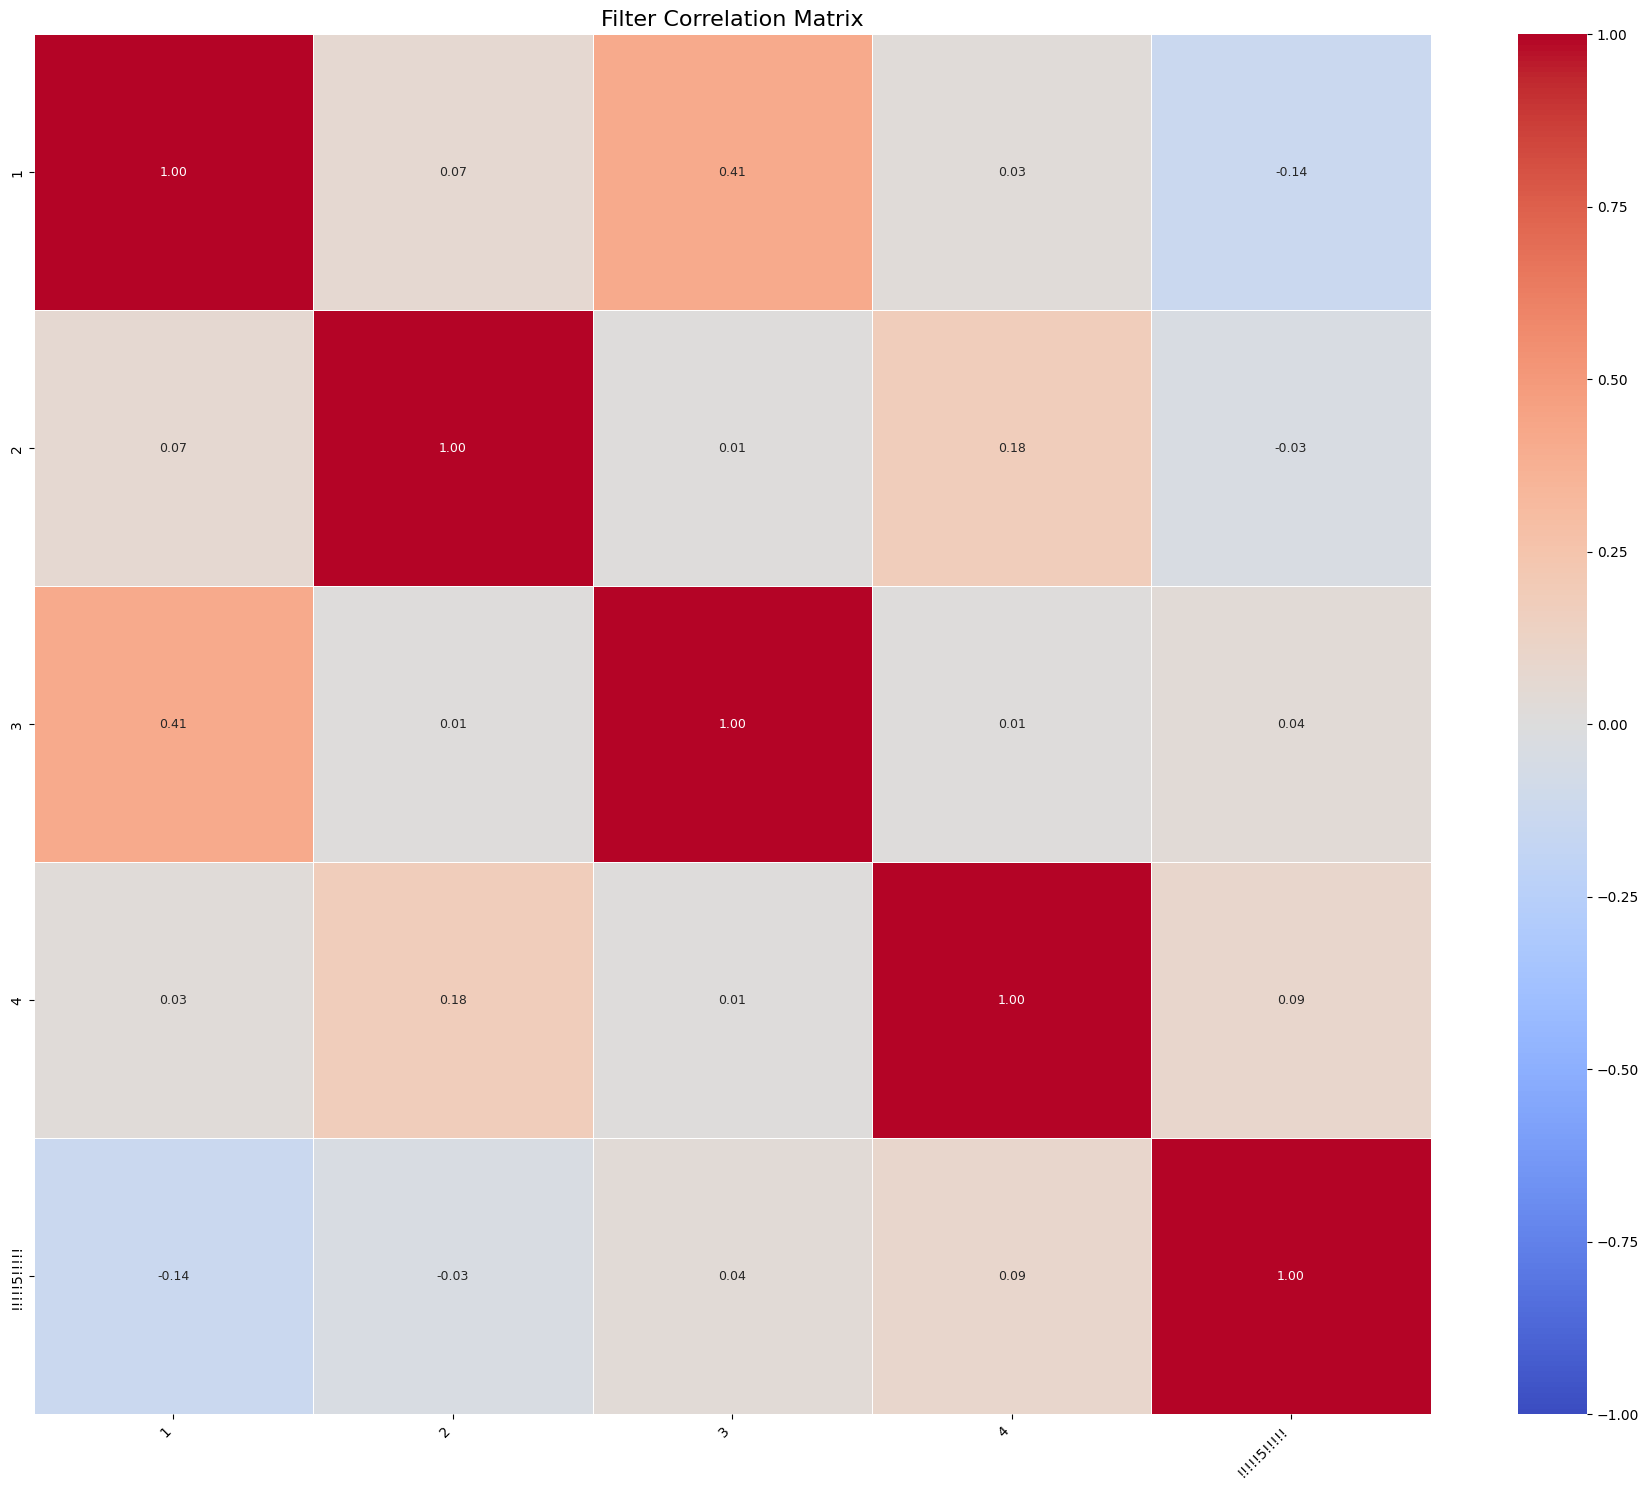

In [6]:
if __name__ == "__main__":
    corr_matrix, filter_results, high_corr_pairs = calculate_filter_correlations()
    plt.show()  # 显示热力图